<a href="https://colab.research.google.com/github/nahbos/AUT-Advanced-Information-Retrieval/blob/main/Ex03/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sobhan Moradian Daghigh

- 2-3-2023

### Ex-03: Recommender System

In [30]:
import numpy as np
import pandas as pd
import json
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# from gensim.models import TfidfModel
# from gensim.corpora import Dictionary
# from gensim.utils import simple_preprocess
# from gensim.parsing.preprocessing import remove_stopwords
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from bs4 import BeautifulSoup
# from collections import Counter
# import random
# import pickle
# from PIL import Image

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part One. 
* Data Loading

In [89]:
with open('./drive/MyDrive/data.json') as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

train = pd.DataFrame(jsonObject['train'])
val   = pd.DataFrame(jsonObject['val'])
test  = pd.DataFrame(jsonObject['test'])

In [90]:
train.head()

,business_id,user_id,rating,review_text,pics,history_reviews
0,60567465d335d0abfb415b26,101074926318992653684,4,The tang of the tomato sauce is outstanding. A...,[https://lh5.googleusercontent.com/p/AF1QipM-2...,[[101074926318992653684_6056272797d555cc6fb0d1...
1,6050fa9f5b4ccec8d5cae994,117065749986299237881,5,Chicken and waffles were really good!,[https://lh5.googleusercontent.com/p/AF1QipMpf...,[[117065749986299237881_605206f8d8c08f462b93e8...
2,604be10877e81aaed3cc9a1e,106700937793048450809,4,The appetizer of colossal shrimp was very good...,[https://lh5.googleusercontent.com/p/AF1QipMNn...,[[106700937793048450809_6044300b27f39b7b5d1dbf...
3,60411e017cd8bf130362365a,101643045857250355161,5,The fish tacos here omg! The salad was great ...,[https://lh5.googleusercontent.com/p/AF1QipM-a...,[[101643045857250355161_604fbdd099686c10168c91...
4,604139dd7cd8bf1303624208,109802745326785766951,4,"Ribs are great, as are the mac and cheese, fri...",[https://lh5.googleusercontent.com/p/AF1QipNVy...,[[109802745326785766951_60524fa9f09a4ffff042f9...


In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87013 entries, 0 to 87012
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      87013 non-null  object
 1   user_id          87013 non-null  object
 2   rating           87013 non-null  int64 
 3   review_text      87013 non-null  object
 4   pics             87013 non-null  object
 5   history_reviews  87013 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.0+ MB


In [92]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10860 entries, 0 to 10859
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      10860 non-null  object
 1   user_id          10860 non-null  object
 2   rating           10860 non-null  int64 
 3   review_text      10860 non-null  object
 4   pics             10860 non-null  object
 5   history_reviews  10860 non-null  object
dtypes: int64(1), object(5)
memory usage: 509.2+ KB


In [93]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11015 entries, 0 to 11014
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      11015 non-null  object
 1   user_id          11015 non-null  object
 2   rating           11015 non-null  int64 
 3   review_text      11015 non-null  object
 4   pics             11015 non-null  object
 5   history_reviews  11015 non-null  object
dtypes: int64(1), object(5)
memory usage: 516.5+ KB


## Preprocess

In [94]:
def preprocess(q):
   
    # Lowercase
    q = str(q).lower().strip()      
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953

    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "was'nt": "was not",
    "were'nt": "were not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Removing Punctuation
    q = "".join([char for char in q if char not in string.punctuation])
    
    # Word Tokenization
    q = word_tokenize(q)
    
    # Stopword Filtering
    stop_words = stopwords.words('english')
    [stop_words.remove(x) for x in ['not', 'very']]
    q = [word for word in q if word not in stop_words]
    
    # Stemming
    porter = PorterStemmer()
    q = [porter.stem(word) for word in q]
    q = ' '.join(q)
    
    return q

In [95]:
preprocess('Hi, no no no the food was awful')

'hi food aw'

In [96]:
preprocess('The best Kentaki ever, thank you')

'best kentaki ever thank'

In [97]:
def text_preprocessor(dataset):
    org = dataset.copy()
    dataset['review_text'] = dataset['review_text'].apply(preprocess)
    
    for row in tqdm(dataset.iterrows()):
        for item in row[1]['history_reviews']:
          item[1] = preprocess(item[1])

    return org, dataset

In [98]:
train_org, train = text_preprocessor(train)
val_org, val = text_preprocessor(val)
test_org, test = text_preprocessor(test)

87013it [04:39, 311.03it/s]
10860it [00:32, 338.10it/s]
11015it [00:37, 295.79it/s]


In [99]:
def obj2int(data):
    x1 = list(set(data.business_id))
    x2 = list(set(data.user_id))

    dic1 = dict(zip(x1, list(range(1, len(x1) + 1))))
    dic2 = dict(zip(x2, list(range(1, len(x2) + 1))))

    data['business_id'] = [dic1[v] for v in data.business_id]
    data['user_id'] = [dic2[v] for v in data.user_id]
    return data

In [101]:
merged = obj2int(pd.concat([train, val, test], ignore_index=True))

train = merged.iloc[:len(train), :]
val = merged.iloc[len(train):len(train) + len(val), :]
test = merged.iloc[-len(test):, :]

In [142]:
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### Split test dataset into some subsets including the users who rated more than n restaurants.

In [143]:
groups = test.groupby(by='user_id')
groups.first()

,business_id,rating,review_text,pics,history_reviews
user_id,,,,,
26,4222,2,think go feel eat ramen unit state,[https://lh5.googleusercontent.com/p/AF1QipPXG...,[[103702125305235331440_6041ef055fd99145bc6215...
28,29081,5,tri shrimp everi way make salad pasta entre sa...,[https://lh5.googleusercontent.com/p/AF1QipOvc...,[[108161276161410360922_604c5092f25393f28ea906...
29,24632,4,plenti garlic appet eat plate eat shrimp shell...,[https://lh5.googleusercontent.com/p/AF1QipMTT...,[[101386921960731069230_6040c0517cd8bf130361fe...
85,7848,5,shrimp scallop veggi mix kid fri oyster clam s...,[https://lh5.googleusercontent.com/p/AF1QipM3t...,[[112809729403235559970_6050b45f0d18f671d86ac1...
102,16528,5,great meat side,[https://lh5.googleusercontent.com/p/AF1QipPkp...,[[109182065259194545017_6043f4f7b81264dfa846d4...
...,...,...,...,...,...
36913,3900,5,restaur perman fixtur san antonio 25 year know...,[https://lh5.googleusercontent.com/p/AF1QipNm1...,[[114212472215495517478_6050ca174cd354c57204c1...
36948,18190,3,photo big island scrambl wipe smoothi realli s...,[https://lh5.googleusercontent.com/p/AF1QipMWV...,[[109695987947107099853_6045ead710ec061e056b38...
36957,29746,5,love blt coffe surprisingli realli delici cour...,[https://lh5.googleusercontent.com/p/AF1QipMdC...,[[112829397259087304433_6056fa31f69c7b11780702...


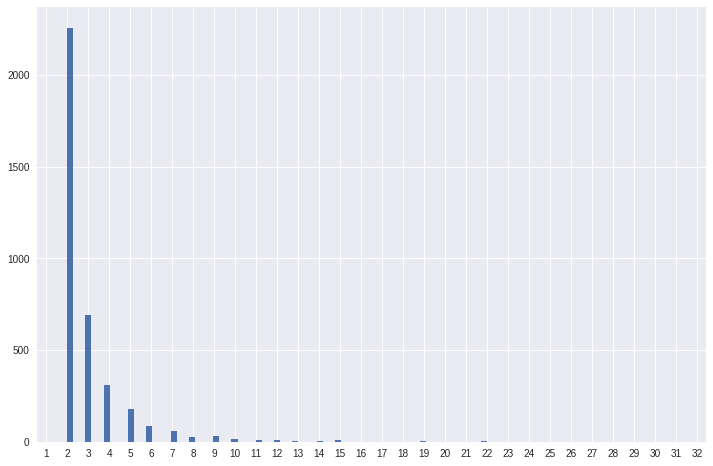

In [144]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(12, 8))
    plt.hist([len(pdf) for grp, pdf in groups], bins=100)
    plt.locator_params(axis='x', nbins=50)
    plt.show()

In [145]:
def user_extractor(dataset, limit=3):
    groups = dataset.groupby(by='user_id')
    for grp, pdf in groups:
        if len(pdf) < limit:
            dataset = dataset[dataset.user_id != grp]
    return dataset

In [146]:
test_includes_2  = user_extractor(dataset=test, limit=2)
test_includes_3  = user_extractor(dataset=test, limit=3)
test_includes_4  = user_extractor(dataset=test, limit=4)
test_includes_5  = user_extractor(dataset=test, limit=5)
test_more_than_5 = user_extractor(dataset=test, limit=6)

**Ok, Everything looks right ))**

# Part Two.
* Evaluation Metrics

### Average Precision (AP)

### Precision @ k

In [19]:
def eval_p_at_k(ref, k_pred):
    pred_relevent = len(set(k_pred).intersection(set(ref)))
    return pred_relevent / len(k_pred)

### Recall @ k

In [50]:
!TODO

/bin/bash: TODO: command not found


# Part Three.
Neural network Recommender System

In [115]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

In [152]:
n_items = len(train.business_id.unique()) + len(val.business_id.unique()) + len(test.business_id.unique())
n_users = len(train.user_id.unique()) + len(val.user_id.unique()) + len(test.user_id.unique())

In [154]:
n_items, n_users

(43611, 36996)

In [177]:
# creating book embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_items + 1, 5, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Books")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([movie_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(64, activation='relu')(fc1)
fc3 = Dense(16, activation='relu')(fc2)
out = Dense(1)(fc3)

# Create model and compile it
model = Model([user_input, movie_input], out)
model.compile('adam', 'mean_squared_error')

In [178]:
history = model.fit([train.user_id, train.business_id], train.rating, epochs=5, validation_data=([val.user_id, val.business_id], val.rating), verbose=1)

Epoch 1/5
2720/2720 [==============================] - 13s 5ms/step - loss: 0.9523 - val_loss: 0.7210
Epoch 2/5
2720/2720 [==============================] - 13s 5ms/step - loss: 0.5038 - val_loss: 0.7742
Epoch 3/5
2720/2720 [==============================] - 13s 5ms/step - loss: 0.3728 - val_loss: 0.8144
Epoch 4/5
2720/2720 [==============================] - 13s 5ms/step - loss: 0.2885 - val_loss: 0.9739
Epoch 5/5
2720/2720 [==============================] - 13s 5ms/step - loss: 0.2171 - val_loss: 0.9435


In [173]:
def get_binary(arr):
    return np.array([1 if x >= 3 else 0 for x in arr])

In [171]:
# creating book embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_items + 2, 5, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Books")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 2, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([movie_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1, activation='sigmoid')(fc2)

# Create model and compile it
model = Model([user_input, movie_input], out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [172]:
history = model.fit([train.user_id, train.business_id], get_binary(train.rating), epochs=5, validation_data=([val.user_id, val.business_id], get_binary(val.rating)), verbose=1)

Epoch 1/5
2720/2720 [==============================] - 14s 5ms/step - loss: 0.1586 - accuracy: 0.9643 - val_loss: 0.1598 - val_accuracy: 0.9622
Epoch 2/5
2720/2720 [==============================] - 15s 5ms/step - loss: 0.0878 - accuracy: 0.9695 - val_loss: 0.2857 - val_accuracy: 0.8905
Epoch 3/5
2720/2720 [==============================] - 12s 4ms/step - loss: 0.0422 - accuracy: 0.9847 - val_loss: 0.4795 - val_accuracy: 0.7662
Epoch 4/5
2720/2720 [==============================] - 12s 4ms/step - loss: 0.0241 - accuracy: 0.9906 - val_loss: 0.6035 - val_accuracy: 0.7155
Epoch 5/5
2720/2720 [==============================] - 12s 4ms/step - loss: 0.0140 - accuracy: 0.9937 - val_loss: 0.7229 - val_accuracy: 0.7120


In [176]:
model.evaluate([test.user_id, test.business_id], get_binary(test.rating))

345/345 [==============================] - 1s 2ms/step - loss: 0.7116 - accuracy: 0.7136


[0.7116390466690063, 0.7135723829269409]

In [174]:
# predictions = model.predict([test.user_id.head(30), test.business_id.head(30)])
# [print(predictions[i], get_binary(test.rating)[i]) for i in range(0, 30)]

In [ ]:
map_ = eval_MAP(ref=query_answer_ref, pred=query_answer_bert)
mrr = eval_MRR(ref=query_answer_ref, pred=query_answer_bert)
avg_p_at_5 = eval_AP(ref=query_answer_ref, pred=query_answer_bert, k=5)
avg_p_at_10 = eval_AP(ref=query_answer_ref, pred=query_answer_bert, k=10)

print('MAP : {:.3f}'.format(map_))
print('MRR : {:.3f}'.format(mrr))
print('P@5 : {:.3f}'.format(avg_p_at_5))
print('P@10: {:.3f}'.format(avg_p_at_10))

MAP : 0.453
MRR : 0.777
P@5 : 0.484
P@10: 0.339


# Part Four.
Siamese

In [ ]:
# Average Precision (AP)
def eval_AP_new(arr):
    relevant = 0
    map = 0
    for i, ele in enumerate(arr):
        if ele == 1:
            relevant += 1
            map += relevant / (i + 1)
    return (map / relevant) if relevant != 0 else 0
     

# Reciprocal Rank (RR)
def eval_RR_new(arr):
    for i, ele in enumerate(arr):
        if ele == 1:
            return 1 / (i + 1)
    return 0


# Precision @ k
def p_at_k_new(arr, k=10):
    return sum(arr[:k]) / k

In [ ]:
eval_ap = eval_AP_new(results)
eval_rr = eval_RR_new(results)
eval_p_at_5 = p_at_k_new(results, k=5)
eval_p_at_10 = p_at_k_new(results)

print('MAP : {:.3f}'.format(eval_ap))
print('MRR : {:.3f}'.format(eval_rr))
print('P@5 : {:.3f}'.format(eval_p_at_5))
print('P@10: {:.3f}'.format(eval_p_at_10))

MAP : 0.747
MRR : 0.865
P@5 : 0.687
P@10: 0.606


# Finito